In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MaxNLocator
from matplotlib.scale import LogScale
import glob
from collections import defaultdict
%matplotlib notebook
import matplotlib
from collections import Counter
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [106]:
map_max_steps = {
    "rooms": 1281,
    "warehouse": 1281,
    "empty64x64": 1281,
    "den520d": 3131
}

la_colors = {
    "plrtalearning": "purple",
    "dijkstralearning": "red",
    "nolearning": "black"
}

num_int_hatch = {
    1:"....",
    3:"\\\\",
}

gs_hatch = {
    "IGen":"....",
    "SubGen":"\\\\",
    "NoGen": "oo"
}

es_hatch = {
    "EI":"....",
    "PI":"\\\\",
    "CW": "oo"
}

la_hatch = {
    "plrtalearning":"....",
    "dijkstralearning":"\\\\",
    "nolearning": "oo"
}

dm_colors = {
    0: "green",
    1: "black",
    2: "blue"
}

def long_uw(uw, ni):
    if uw == "NA":
        return "Safe Interval Wait-" + str(ni)
    else:
        return "Unit Wait (" + str(uw) + ")"
    
long_dm = {
    0: "<x,y,t>",
    1: "<x,y,i>-int",
    2: "<x,y,i>-subinterval"
}

colors = ["green", "red", "blue", "grey"]
labels = ["survived", "died", "timed out", "stepped out"]

plot_folder = "results_plots/"

In [101]:
data = pd.read_csv("data_temp2.csv", index_col = 0, na_values=[],keep_default_na = False)
#ref_dat = pd.read_csv("data_reference.csv", index_col = 0, na_values=[],keep_default_na = False)
#reference = defaultdict(dict)
#for i in ref_dat.index:
#    reference[ref_dat.loc[i, "map"]][ref_dat.loc[i, "task"]] = ref_dat.loc[i, "solution duration"]

In [79]:
set(data["gen scheme"])

{'IGen', 'NoGen', 'SubGen'}

11777    NA
2119     NA
4540     NA
2140     NA
8312     NA
         ..
2884     NA
11278    NA
4029     NA
4054     NA
9340     NA
Name: unitWait, Length: 149, dtype: object

In [54]:
learn_names = {
    "nolearning": "NoLearn",
    "dijkstralearning": "LSS-LRTA*",
    "plrtalearning": "PLRTA*", 
}
generalization_names = {
    0: "NoGen",
    1: "IGen",
    2: "SubGen"
}

def expansion_names(unitwait, dynmode, numintervals):
    if dynmode == 2:
        return "PI-" + str(numintervals)
    if unitwait == "NA":
        return "EI-" + str(numintervals)
    return "CW-" + str(unitwait)
    

In [102]:
uwait = data["unitWait"]
dm = data["dynmode"]
ni = data["numIntervals"]
es = []
for i in data.index:
    es.append(expansion_names(uwait[i], dm[i], ni[i]))
data["expansion scheme"] = es

In [103]:
data["gen scheme"] = data.dynmode.apply(lambda x: generalization_names[x])
data["expansion scheme family"] = data["expansion scheme"].apply(lambda x: x[0:2])
data["learn scheme"] = data["learning algorithm"].apply(lambda x: learn_names[x])

In [87]:
data["expansion scheme family"]

0         EI
1         PI
2         PI
3         EI
4         EI
          ..
110777    CW
110778    CW
110779    EI
110780    EI
110781    CW
Name: expansion scheme family, Length: 110782, dtype: object

In [78]:
filt = {
 'map': "rooms",
 'expansion algorithm': "astar",
 'learning algorithm': "plrtalearning",
 'decision algorithm': "miniminbackup",
 'dynmode': 1, 
 'unitWait': "NA",
 'numIntervals': 1
}

def filter_data(data, filt):
    dat = data
    for col in filt:
        dat = dat.loc[dat[col] == filt[col]] 
    return dat

def survival_rate(dat):
    total = len(dat)
    
    survived_ind = dat.agentFate == "survived"
    sci = bootstrap_ci(survived_ind)/total
    survived = (survived_ind.sum()/total, sci[0], sci[1])
    
    
    died = dat.agentFate == "died"
    dci = bootstrap_ci(died)/total
    died = (died.sum()/total, dci[0], dci[1])
    
    to = ((dat.agentFate == "timed out") & (dat.steps != dat.map.apply(lambda x: map_max_steps[x])))
    toci = bootstrap_ci(to)/total
    to = (to.sum()/total, toci[0], toci[1])
    
    
    so = ((dat.agentFate == "timed out") & (dat.steps == dat.map.apply(lambda x: map_max_steps[x])))
    soci = bootstrap_ci(so)/total
    so = (so.sum()/total, soci[0], soci[1])
    
    sd = dat.loc[survived_ind]
    
    return survived, died, to, so

#sm.stats.proportion_confint(survived, total, 0.05, "beta")

def bootstrap_ci(dat, n = 2**10):
    return np.percentile(np.sum(np.random.choice(dat.values, (n, len(dat))), axis = 1), (5, 95))

def pre_plot():
    ax = plt.figure()
    plt.xscale(LogScale(ax, base = 2))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

def post_plot(l = (0, 100)):
    plt.ylabel("Percent survived")
    plt.xlabel("Expansion rate")
    plt.ylim(l)
    plt.legend(loc='lower right')
    plt.savefig(plot_folder + title.replace(" ", "_")+".png", dpi = 300)
    plt.close()

def plot_one(dat, i, hatch, la, label):
    lookahead = list(sorted(set(dat.lookahead)))
    res = []
    for l in lookahead:
        ldat = dat.loc[dat.lookahead == l]
        res.append(survival_rate(ldat))
    res = np.asarray(res)
    #if c:
    plt.plot(lookahead, 100*res[:, i, 0], "k")
    plt.fill_between(lookahead, 100*res[:, i, 1],100*res[:, i, 2],edgecolor = "black", facecolor = "white" ,hatch = hatch, alpha = 0.5, label = label )
    #else:
    #    plt.plot(lookahead, 100*res[:, i, 0])
    #    plt.fill_between(lookahead, 100*res[:, i, 1],100*res[:, i, 2], alpha = 0.45, label =learn_names[la])

In [105]:
data

map  task expansion algorithm learning algorithm  \
0            rooms   378               astar      plrtalearning   
1            rooms   323               astar      plrtalearning   
2       empty64x64   116               astar   dijkstralearning   
3            rooms   420               astar   dijkstralearning   
4        warehouse   129               astar         nolearning   
...            ...   ...                 ...                ...   
372282       rooms   128               astar   dijkstralearning   
372283       rooms   267               astar      plrtalearning   
372284       rooms   499               astar      plrtalearning   
372285     den520d    55               astar      plrtalearning   
372286       rooms   204               astar   dijkstralearning   

       decision algorithm  lookahead  dynmode unitWait  numIntervals  \
0           miniminbackup         16        0       NA             3   
1           miniminbackup          4        2       NA             1   
2           miniminbackup         32        2       NA             3   
3           miniminbackup       1024        2       NA             3   
4           miniminbackup          2        2       NA             1   
...                   ...        ...      ...      ...           ...   
372282      miniminbackup        128        0      0.1             1   
372283      miniminbackup          2        1       NA             1   
372284      miniminbackup          4        1       NA             3   
372285      miniminbackup         32        2       NA             3   
372286      miniminbackup         32        1      0.1             1   

        agentFate  ... steps  totalExpansions  user time expansion  \
0            died  ...    27              463                  0.0   
1            died  ...     3               13                  0.0   
2        survived  ...    70             2196                  0.0   
3            died  ...    69            88463                  0.0   
4            died  ...    12               25                  0.0   
...           ...  ...   ...              ...                  ...   
372282  timed out  ...  1281           199466                  0.0   
372283       died  ...    28               56                  0.0   
372284       died  ...    28              117                  0.0   
372285       died  ...   100             3605                  0.0   
372286       died  ...    29             1046                  0.0   

        user time learning  user time decision  \
0                      0.0                 0.0   
1                      0.0                 0.0   
2                      0.0                 0.0   
3                      0.0                 0.0   
4                      0.0                 0.0   
...                    ...                 ...   
372282                 0.0                 0.0   
372283                 0.0                 0.0   
372284                 0.0                 0.0   
372285                 0.0                 0.0   
372286                 0.0                 0.0   

        user time safe interval generation  expansion scheme gen scheme  \
0                                      0.0              EI-3      NoGen   
1                                      0.0              PI-1     SubGen   
2                                      0.0              PI-3     SubGen   
3                                      0.0              PI-3     SubGen   
4                                      0.0              PI-1     SubGen   
...                                    ...               ...        ...   
372282                                 0.0            CW-0.1      NoGen   
372283                                 0.0              EI-1       IGen   
372284                                 0.0              EI-3       IGen   
372285                                 0.0              PI-3     SubGen   
372286                                 0.0            CW-0.1       IGen   

  

<IPython.core.display.Javascript object>


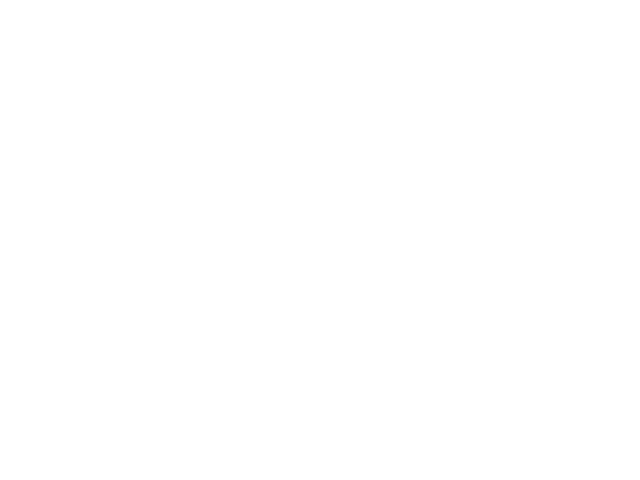

<IPython.core.display.Javascript object>


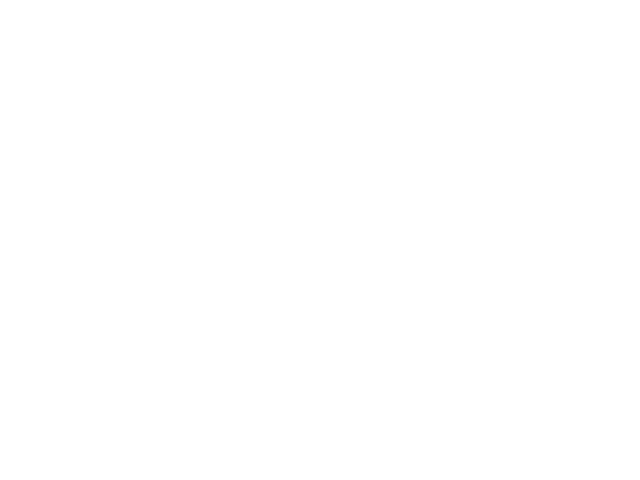

<IPython.core.display.Javascript object>


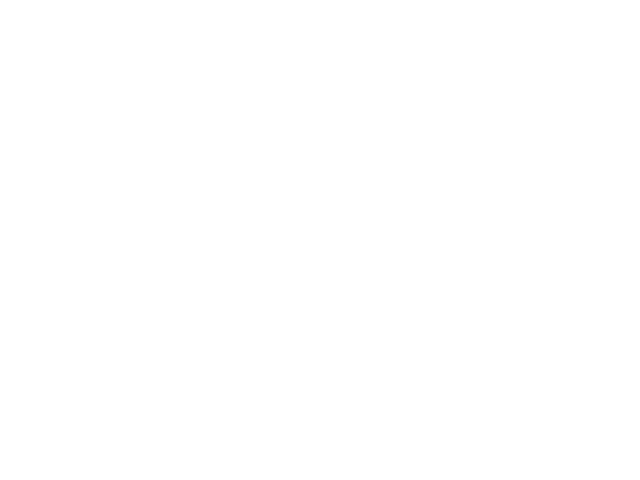

<IPython.core.display.Javascript object>


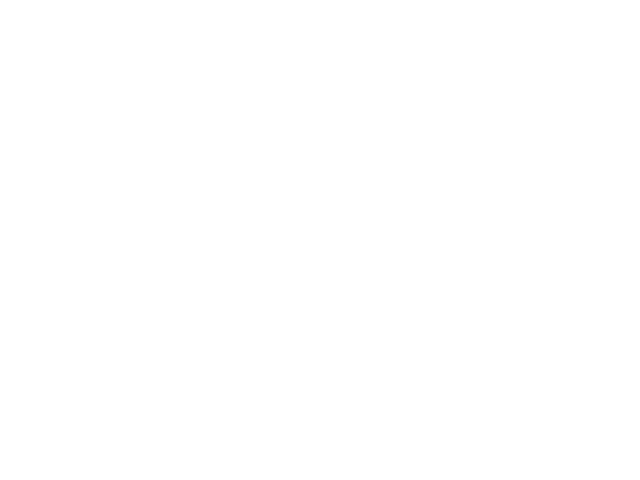

<IPython.core.display.Javascript object>


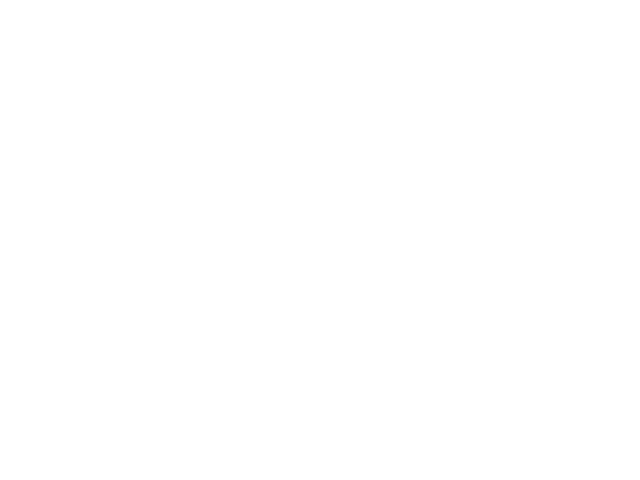

<IPython.core.display.Javascript object>


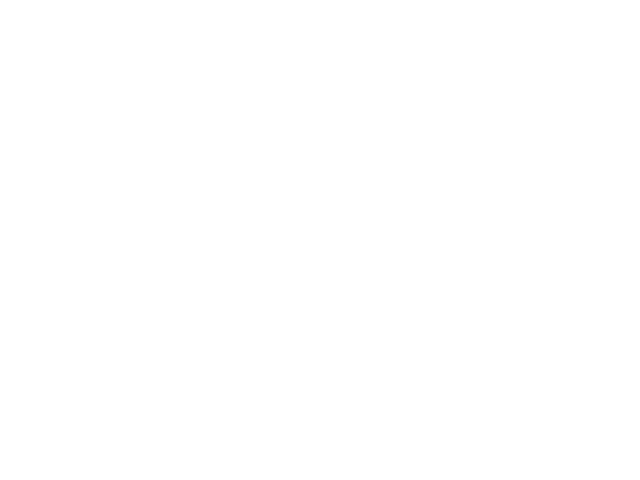

<IPython.core.display.Javascript object>


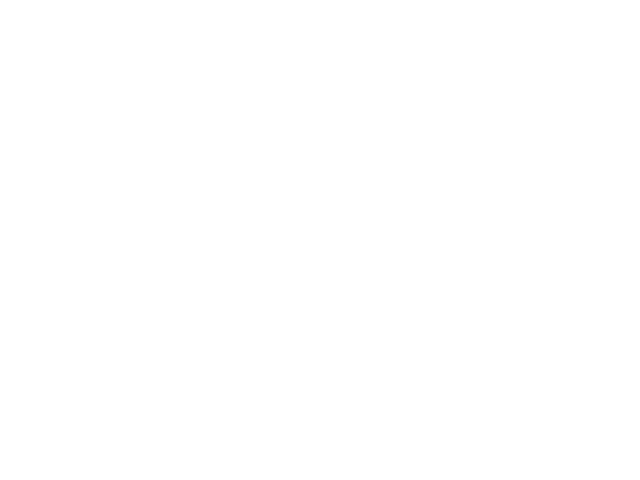

<IPython.core.display.Javascript object>


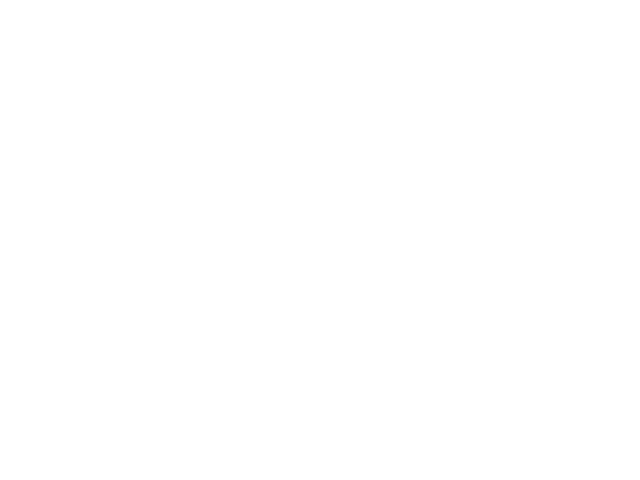

<IPython.core.display.Javascript object>


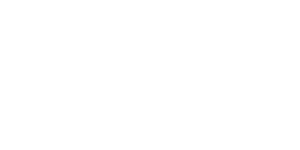

<IPython.core.display.Javascript object>


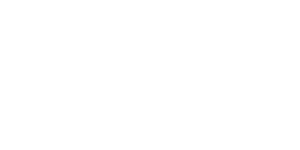

<IPython.core.display.Javascript object>


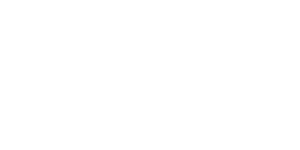

<IPython.core.display.Javascript object>


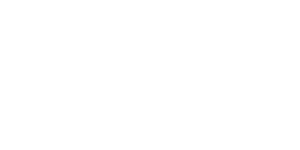

<IPython.core.display.Javascript object>


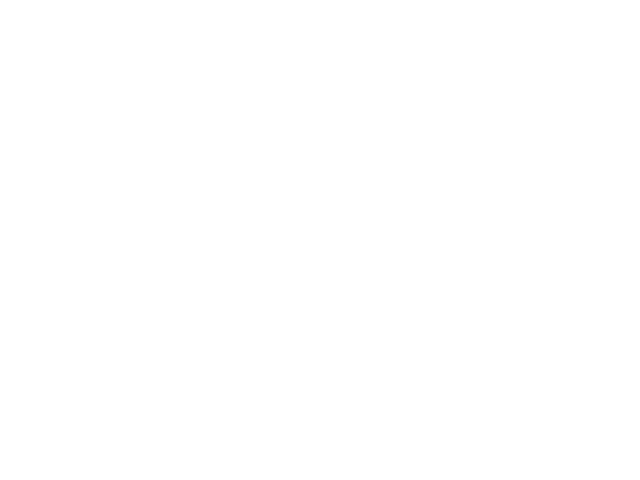

<IPython.core.display.Javascript object>


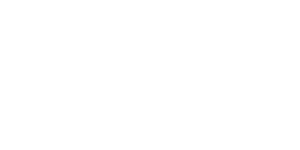

<IPython.core.display.Javascript object>


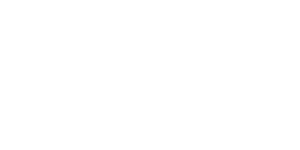

<IPython.core.display.Javascript object>


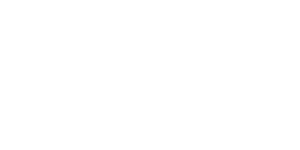

<IPython.core.display.Javascript object>


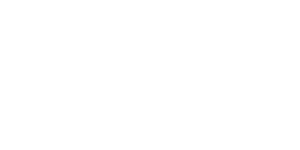

<IPython.core.display.Javascript object>


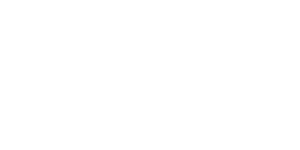

<IPython.core.display.Javascript object>


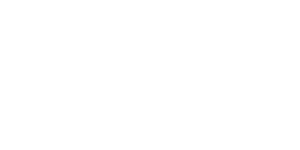

<IPython.core.display.Javascript object>


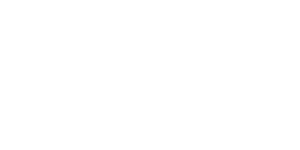

<IPython.core.display.Javascript object>


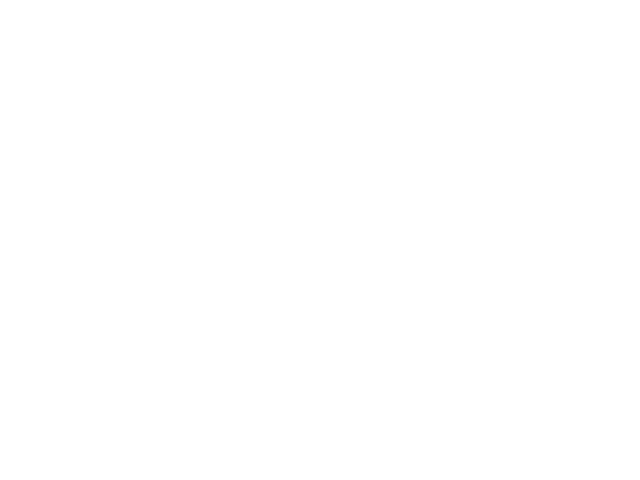

<IPython.core.display.Javascript object>


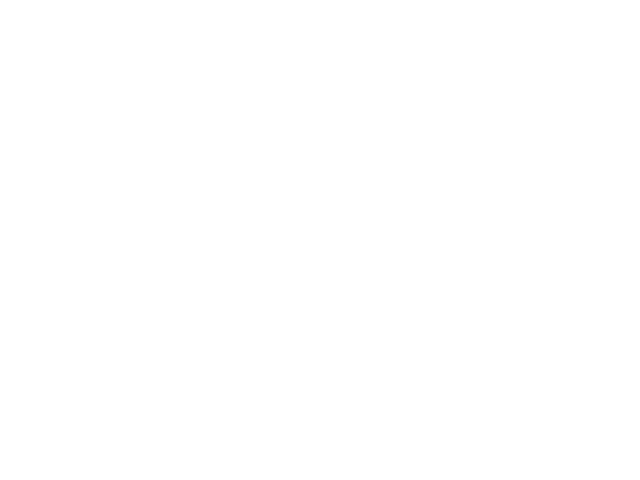

<IPython.core.display.Javascript object>


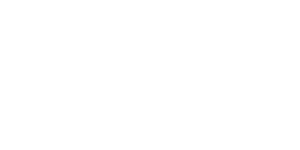

<IPython.core.display.Javascript object>


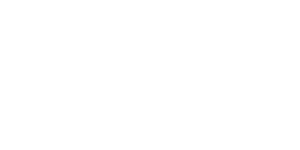

<IPython.core.display.Javascript object>


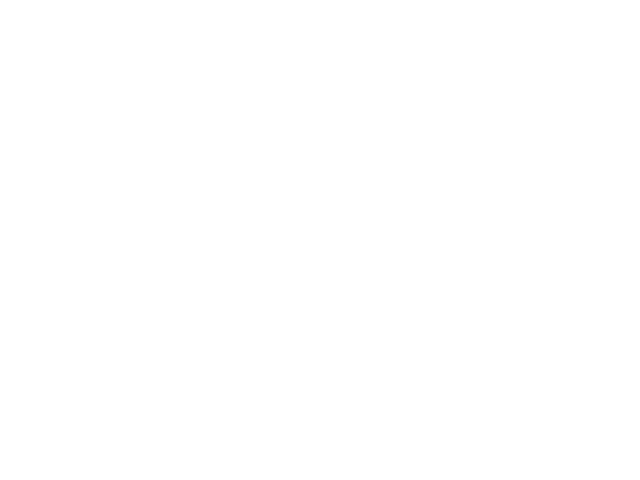

<IPython.core.display.Javascript object>


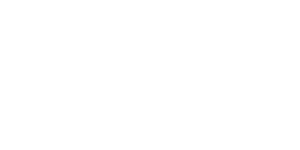

<IPython.core.display.Javascript object>


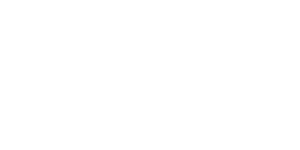

<IPython.core.display.Javascript object>


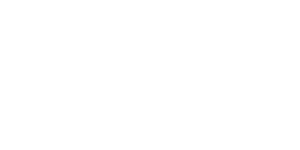

<IPython.core.display.Javascript object>


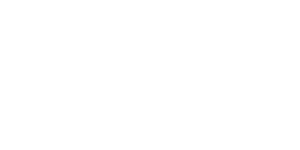

<IPython.core.display.Javascript object>


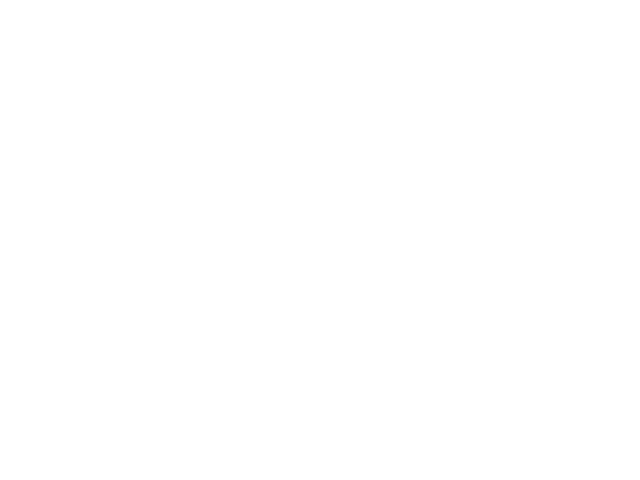

<IPython.core.display.Javascript object>


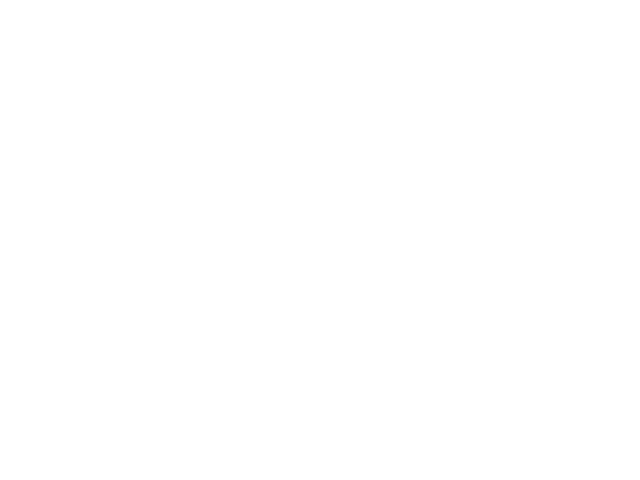

<IPython.core.display.Javascript object>


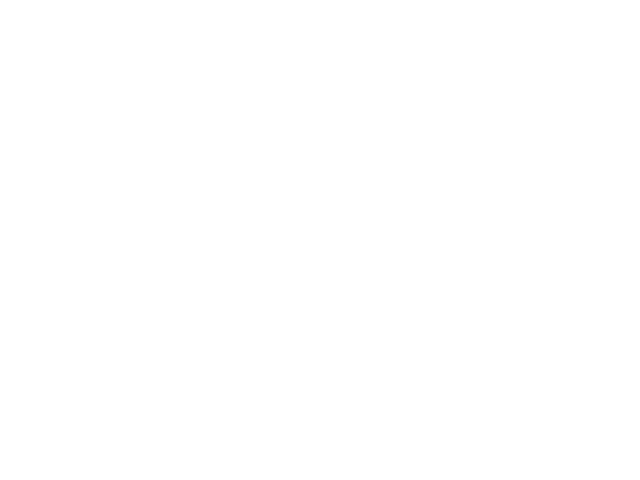

'    \n    \n    for uw in set(data.unitWait) - {"NA"}:\n            filt["unitWait"] = uw\n            filt["numIntervals"] = 1\n            dat = filter_data(data, filt)\n            if len(dat) > 0:\n                pre_plot()\n                for la in set(data["learning algorithm"]):\n                    d = dat.loc[dat["learning algorithm"] == la]\n                    plot_one(d, 0, la_colors[la], la)\n                title = filt["map"] + test + ", ".join(map(str, (m, long_dm[dm], long_uw(uw, ni))))\n                plt.title(test + ", ".join(map(str, (m, long_dm[dm], long_uw(uw, ni)))))\n                post_plot()\n                '

In [121]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  'expansion scheme': "",
  "gen scheme":"",
}

test = "Learning Method Comparison "

for m in set(data.map):
    filt["map"] = m
    for es in set(data["expansion scheme"]):
        filt["expansion scheme"] = es
        for gs in set(data["gen scheme"]):
            filt["gen scheme"] = gs
            dat = filter_data(data, filt)
            if len(dat) > 0:
                pre_plot()
                for la in learn_names:
                    d = dat.loc[dat["learning algorithm"] == la]
                    plot_one(d, 0, la_hatch[la], la, "+".join((es, gs, learn_names[la])))
                title = test + " ".join((m, es, gs))
                plt.title(title)
                post_plot()
       
    
    
    
    
"""    
    
    for uw in set(data.unitWait) - {"NA"}:
            filt["unitWait"] = uw
            filt["numIntervals"] = 1
            dat = filter_data(data, filt)
            if len(dat) > 0:
                pre_plot()
                for la in set(data["learning algorithm"]):
                    d = dat.loc[dat["learning algorithm"] == la]
                    plot_one(d, 0, la_colors[la], la)
                title = filt["map"] + test + ", ".join(map(str, (m, long_dm[dm], long_uw(uw, ni))))
                plt.title(test + ", ".join(map(str, (m, long_dm[dm], long_uw(uw, ni)))))
                post_plot()
                """

<IPython.core.display.Javascript object>


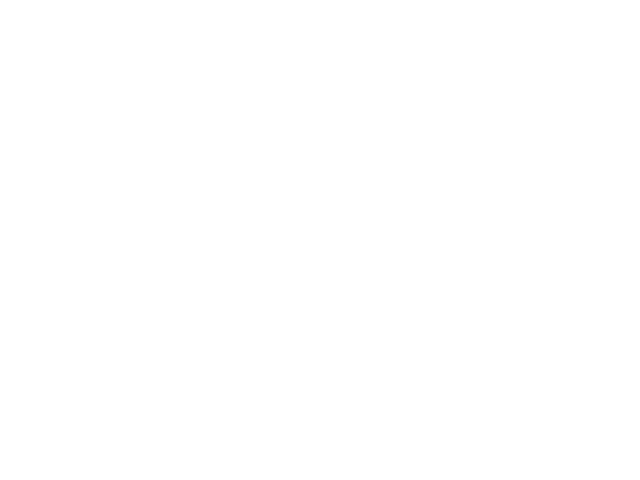

<IPython.core.display.Javascript object>


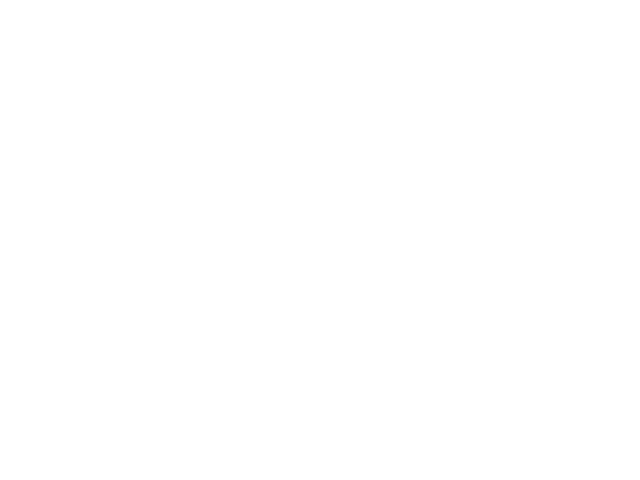

<IPython.core.display.Javascript object>


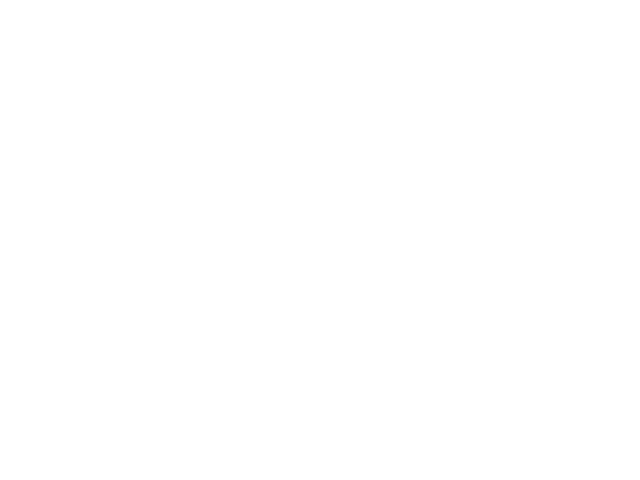

<IPython.core.display.Javascript object>


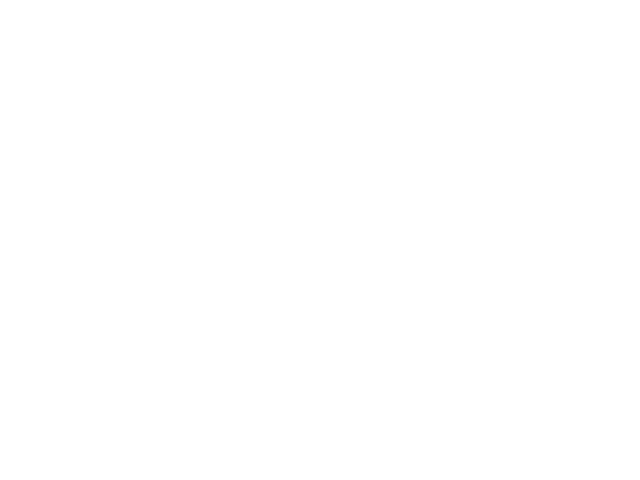

<IPython.core.display.Javascript object>


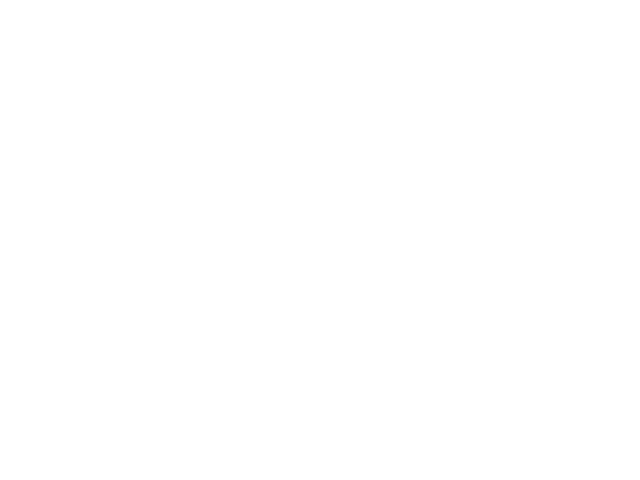

<IPython.core.display.Javascript object>


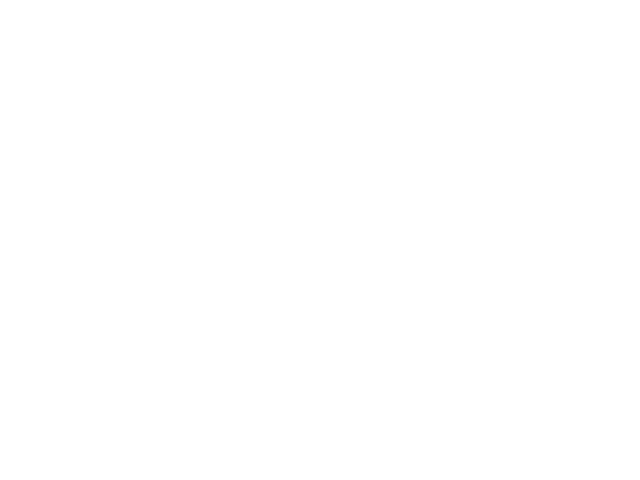

<IPython.core.display.Javascript object>


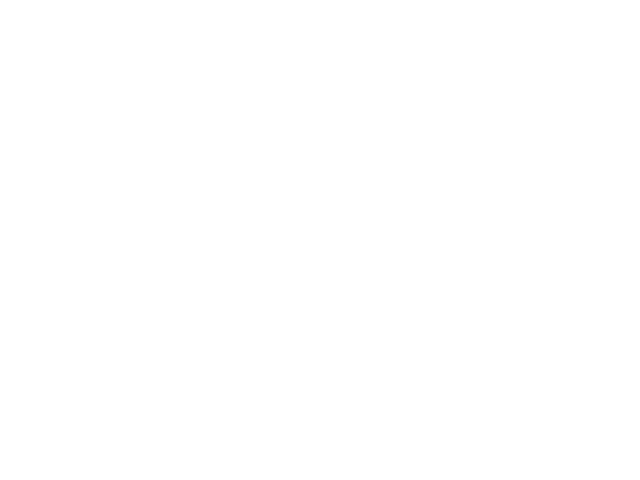

<IPython.core.display.Javascript object>


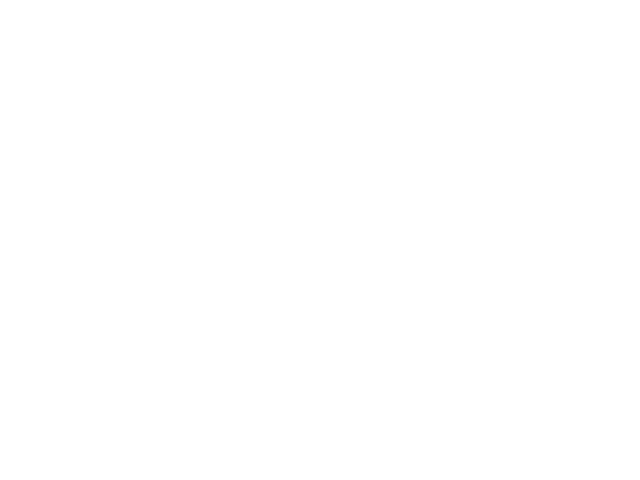

<IPython.core.display.Javascript object>


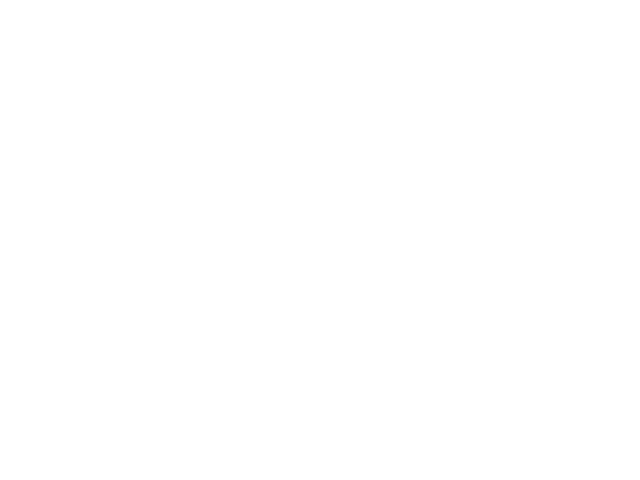

<IPython.core.display.Javascript object>


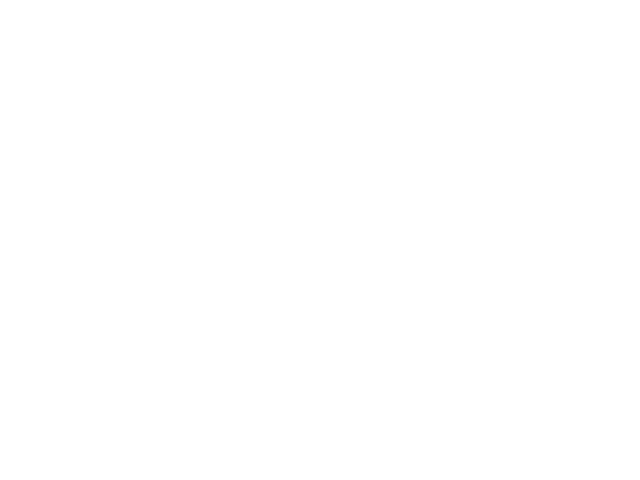

<IPython.core.display.Javascript object>


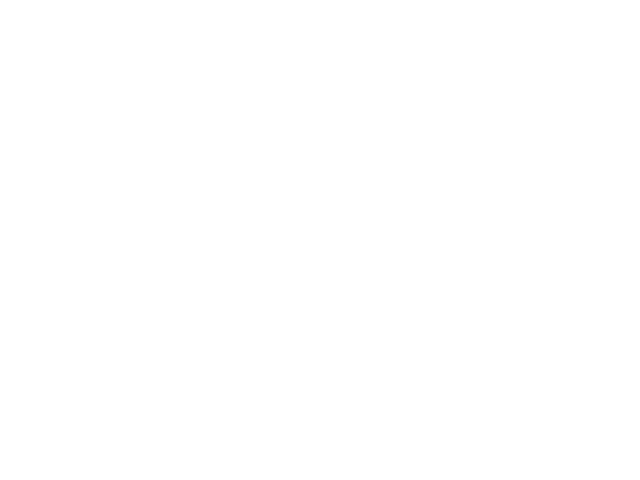

<IPython.core.display.Javascript object>


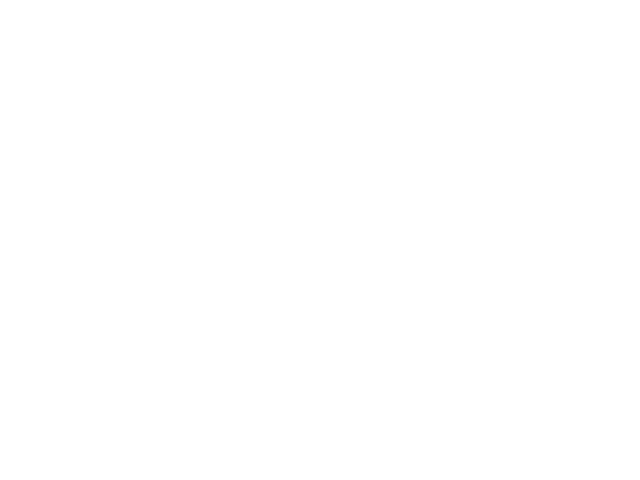

<IPython.core.display.Javascript object>


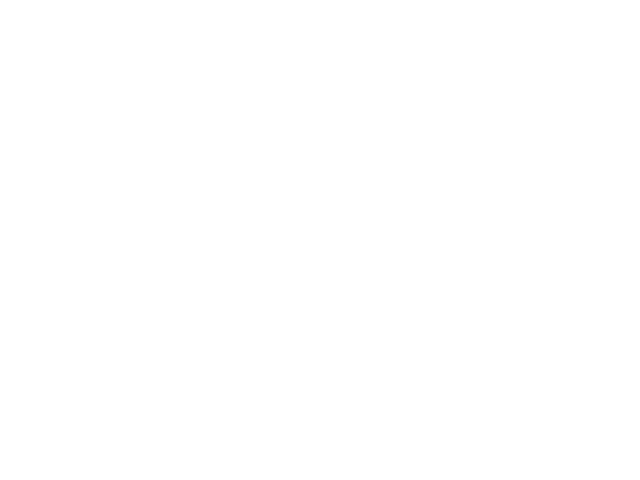

<IPython.core.display.Javascript object>


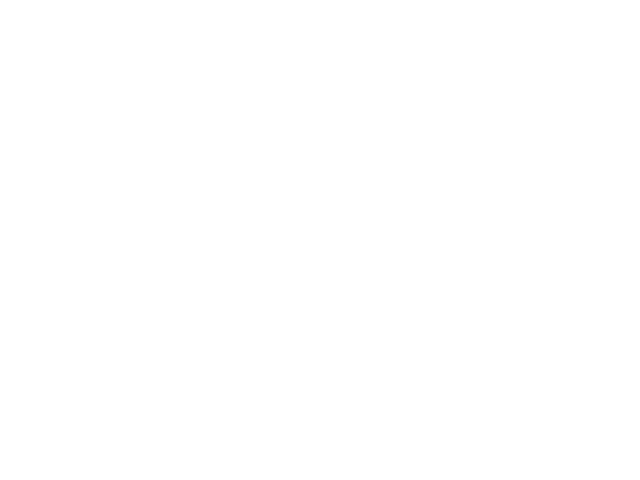

<IPython.core.display.Javascript object>


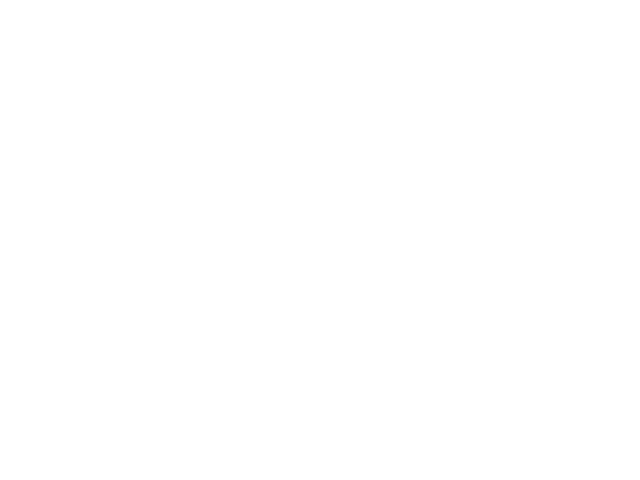

In [119]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  'expansion scheme': "",
  "gen scheme":"",
}

test = "Generalization Method Comparison "

for m in ["rooms", "warehouse", "den520d"]:
    filt["map"] = m
    for es in set(data["expansion scheme"]):
        filt["expansion scheme"] = es
        pre_plot()
        for gs in set(data["gen scheme"]):
            filt["gen scheme"] = gs
            dat = filter_data(data, filt)
            if len(dat) > 0:
                for la in ["plrtalearning"]:
                    d = dat.loc[dat["learning algorithm"] == la]
                    plot_one(d, 0, gs_hatch[gs], la, "+".join((es, gs, learn_names[la])))
        title = test + " ".join((m, es))
        plt.title(title)
        post_plot()

<IPython.core.display.Javascript object>


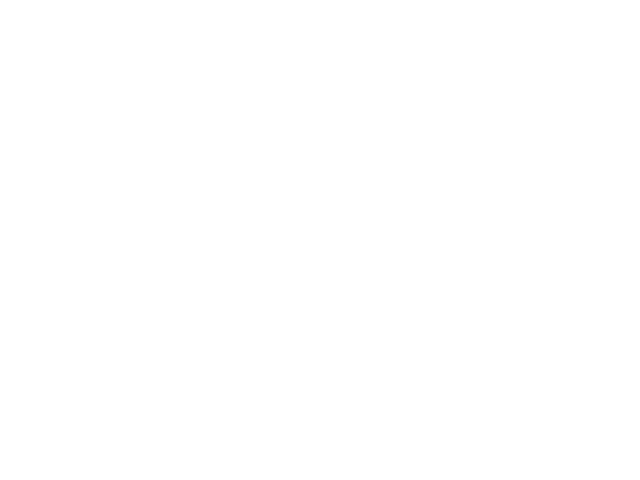

In [122]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  'expansion scheme': "",
  "gen scheme":"",
}

toplot = [
    ("PI-3", "SubGen", "plrtalearning", "////"),
    ("PI-1", "SubGen", "plrtalearning", "\\\\"),
    ("CW-0.1", "NoGen", "nolearning", "oooo"),
    ("EI-1", "NoGen", "nolearning", "....")
]

test = "Best Comparison "

m = "empty64x64"
filt["map"] = m
pre_plot()
for es, gs, la, hatch in toplot:
    filt["expansion scheme"] = es
    filt["gen scheme"] = gs
    dat = filter_data(data, filt)
    d = dat.loc[dat["learning algorithm"] == la]
    plot_one(d, 0, hatch, la, "+".join((es, gs, learn_names[la])))
    
title = test + " ".join((m,))
#plt.title(title)
post_plot()

<IPython.core.display.Javascript object>


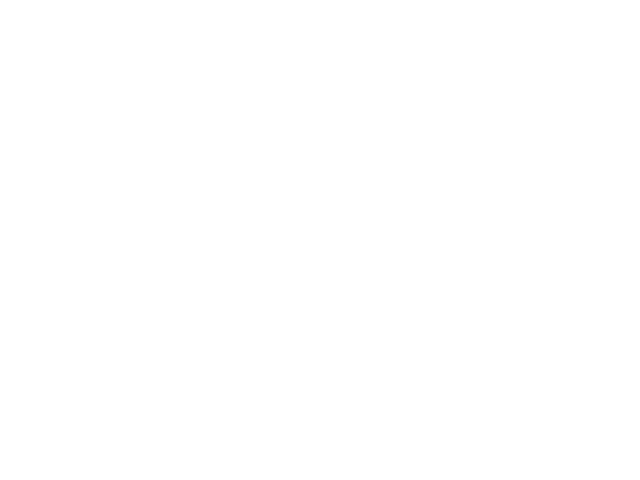

<IPython.core.display.Javascript object>


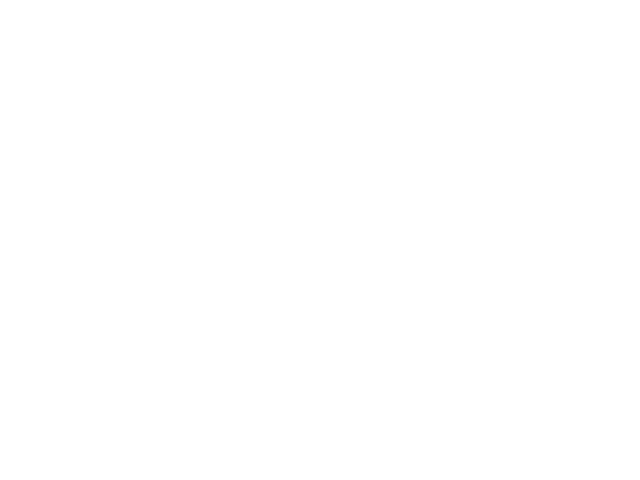

<IPython.core.display.Javascript object>


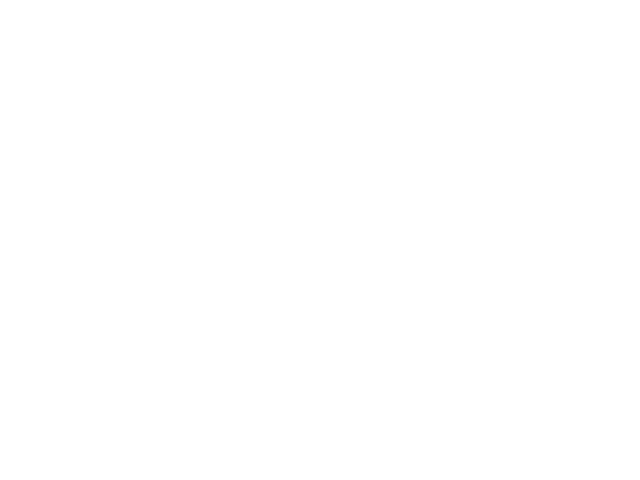

In [123]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  "gen scheme":"",
}

test = "Best Comparison "

best_gs = {
    "PI": "SubGen",
    "EI": "NoGen",
    "CW": "NoGen"
}

best_es = {
    "PI": "PI-3",
    "EI": "EI-3",
    "CW": "CW-0.1"
}



for m in ["rooms", "den520d", "warehouse"]:
    filt["map"] = m
    pre_plot()
    for es in set(data["expansion scheme family"]):
        filt["expansion scheme family"] = es
        gs = best_gs[es]
        filt["gen scheme"] = gs
        dat = filter_data(data, filt)
        e = best_es[es]
        if len(dat) > 0:
            for la in ["plrtalearning"]:
                d = dat.loc[(dat["learning algorithm"] == la) & (dat["expansion scheme"] == e)]
                plot_one(d, 0,es_hatch[es], la, "+".join((e, gs, learn_names[la])))
    title = test + " ".join((m,))
    #plt.title(title)
    post_plot()

<IPython.core.display.Javascript object>


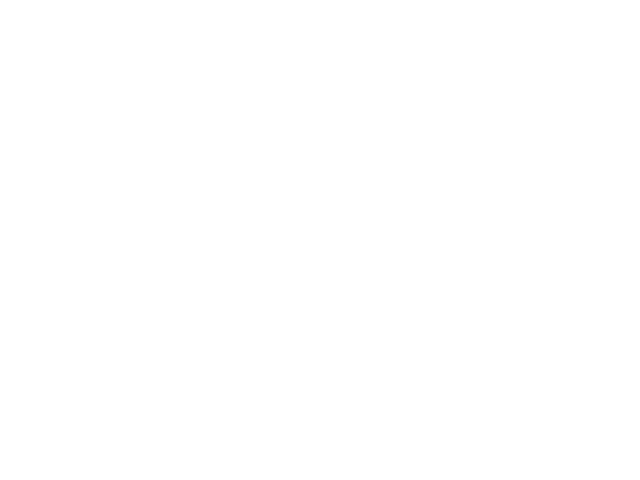

<IPython.core.display.Javascript object>


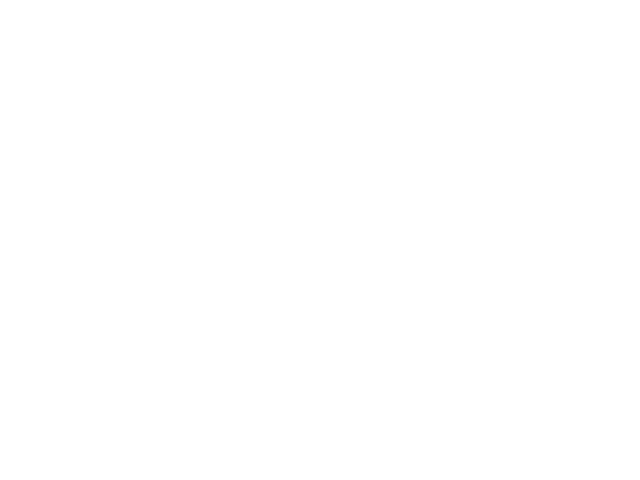

<IPython.core.display.Javascript object>


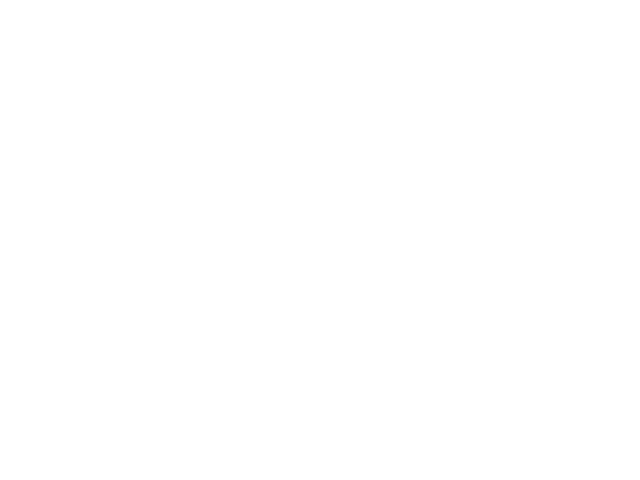

<IPython.core.display.Javascript object>


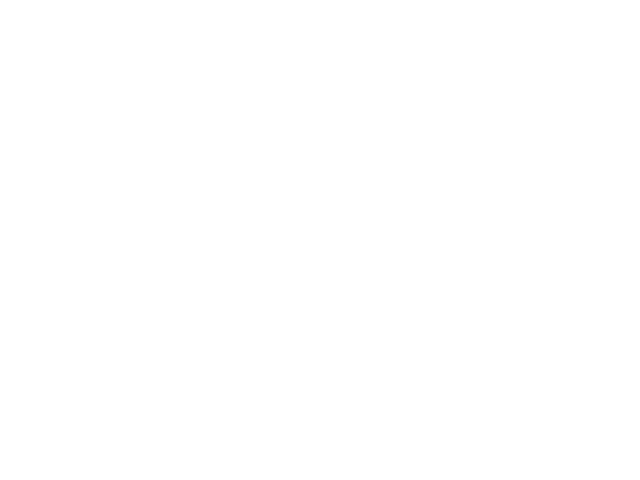

<IPython.core.display.Javascript object>


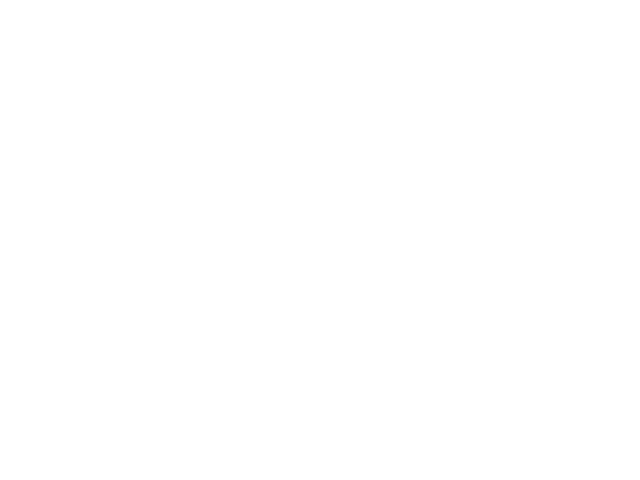

<IPython.core.display.Javascript object>


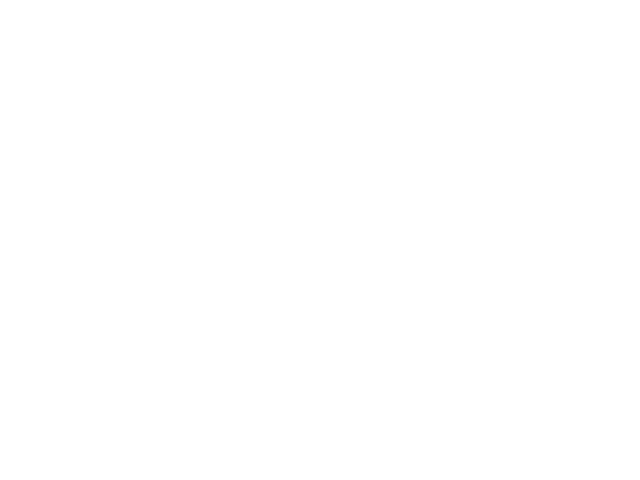

<IPython.core.display.Javascript object>


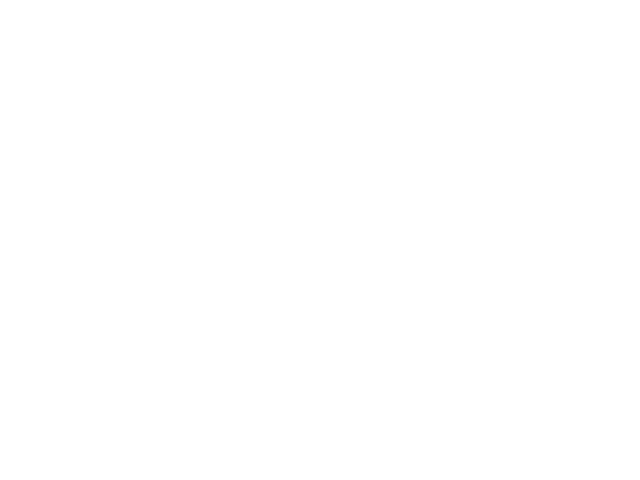

<IPython.core.display.Javascript object>


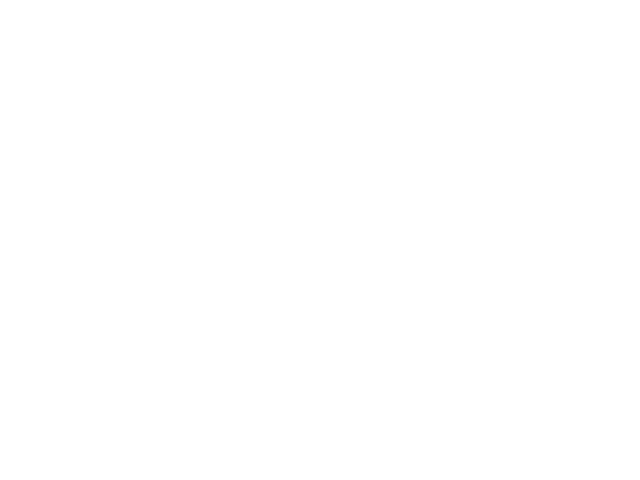

<IPython.core.display.Javascript object>


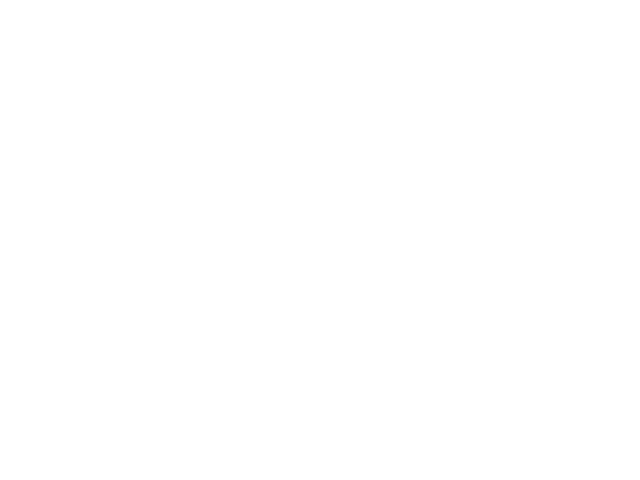

<IPython.core.display.Javascript object>


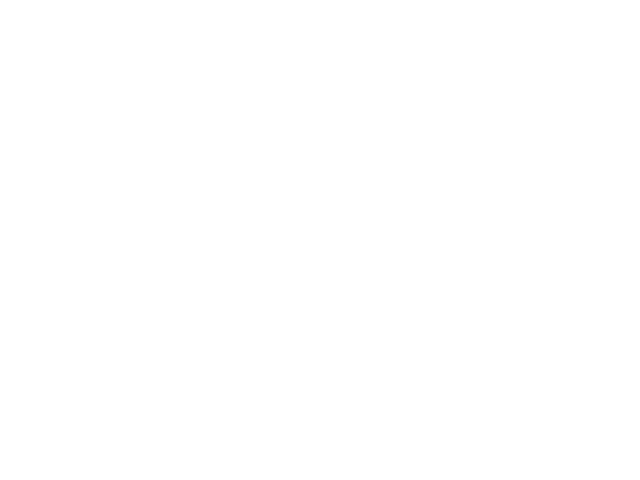

<IPython.core.display.Javascript object>


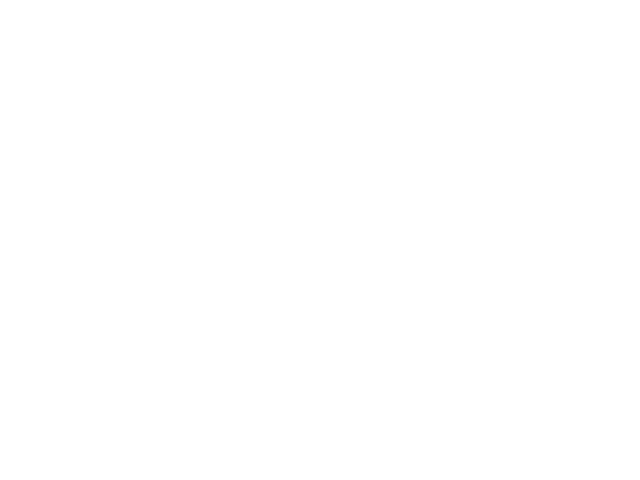

<IPython.core.display.Javascript object>


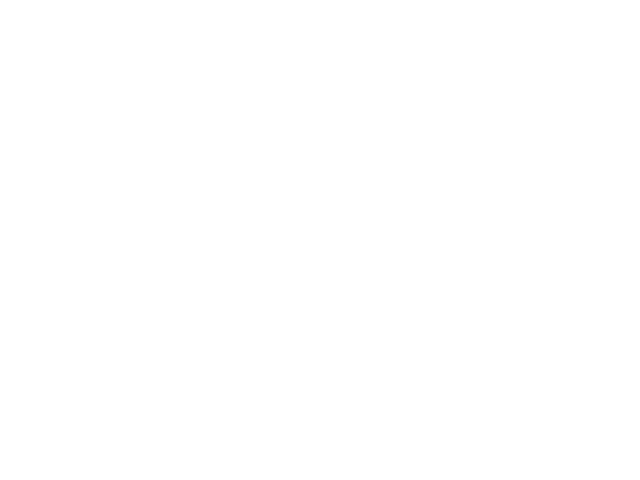

In [115]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  "gen scheme":"",
}

test = "Expansion method Comparison "

best_gs = {
    "PI": "SubGen",
    "EI": "NoGen",
    "CW": "NoGen"
}

for m in set(data.map):
    filt["map"] = m
    for es in set(data["expansion scheme family"]):
        pre_plot()
        filt["expansion scheme family"] = es
        gs = best_gs[es]
        filt["gen scheme"] = gs
        dat = filter_data(data, filt)
        
        for e in set(dat["expansion scheme"]):
            if len(dat) > 0:
                for la in ["plrtalearning"]:
                    d = dat.loc[(dat["learning algorithm"] == la) & (dat["expansion scheme"] == e)]
                    plot_one(d, 0, num_int_hatch[int(e[-1])], la, e)
        title = test + " ".join((m, es))
        plt.title(title)
        post_plot()

<IPython.core.display.Javascript object>


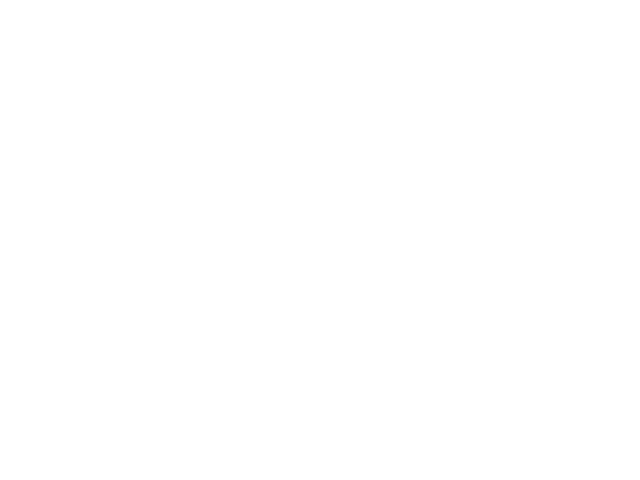

<IPython.core.display.Javascript object>


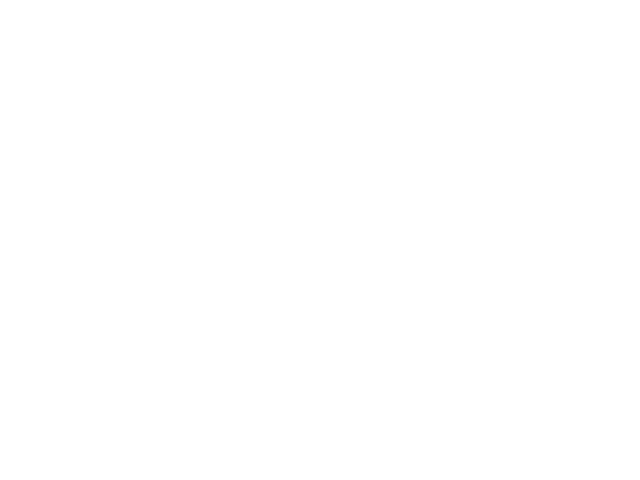

<IPython.core.display.Javascript object>


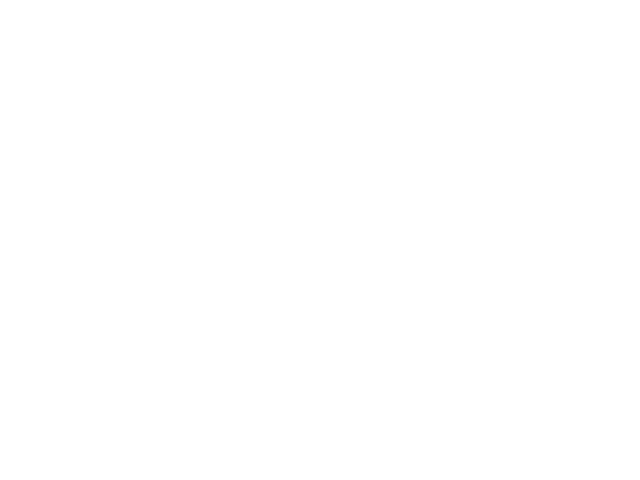

In [118]:
## Look at best learning algorithm for all others
filt = {
  'map': "den520",
  "gen scheme":"",
}

test = "Best Comparison "

best_gs = {
    "PI": "SubGen",
    "EI": "NoGen",
    "CW": "NoGen"
}

best_es = {
    "PI": "PI-3",
    "EI": "EI-3",
    "CW": "CW-0.1"
}



for m in ["rooms", "warehouse", "den520d"]:
    filt["map"] = m
    pre_plot()
    for es in set(data["expansion scheme family"]):
        filt["expansion scheme family"] = es
        gs = best_gs[es]
        filt["gen scheme"] = gs
        dat = filter_data(data, filt)
        e = best_es[es]
        if len(dat) > 0:
            for la in ["plrtalearning"]:
                d = dat.loc[(dat["learning algorithm"] == la) & (dat["expansion scheme"] == e)]
                plot_one(d, 0,es_hatch[es], la, e)
    title = test + " ".join((m,))
    #plt.title(title)
    post_plot()

<IPython.core.display.Javascript object>


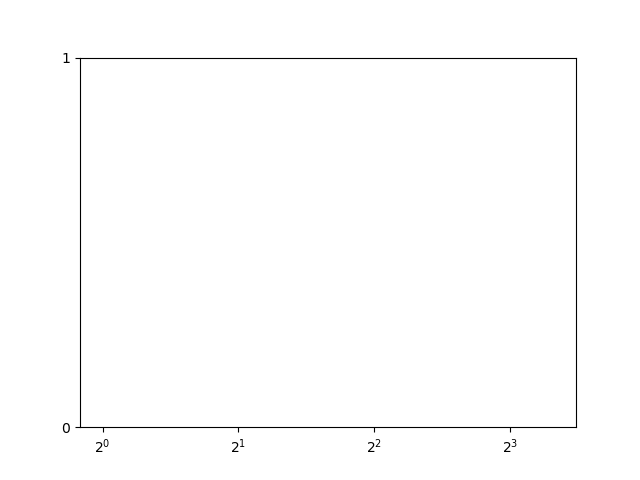

<IPython.core.display.Javascript object>


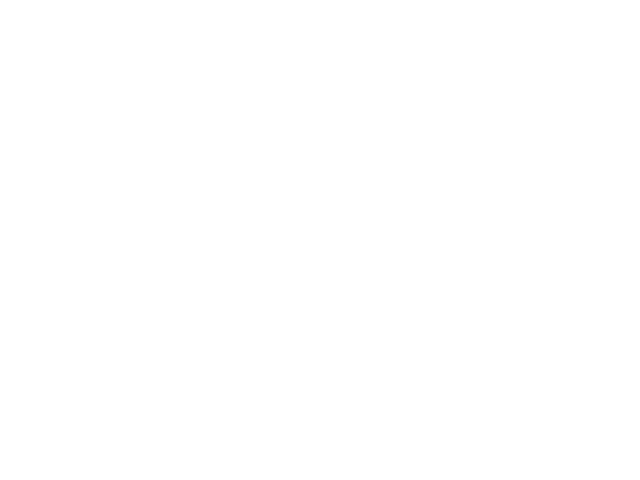

<IPython.core.display.Javascript object>


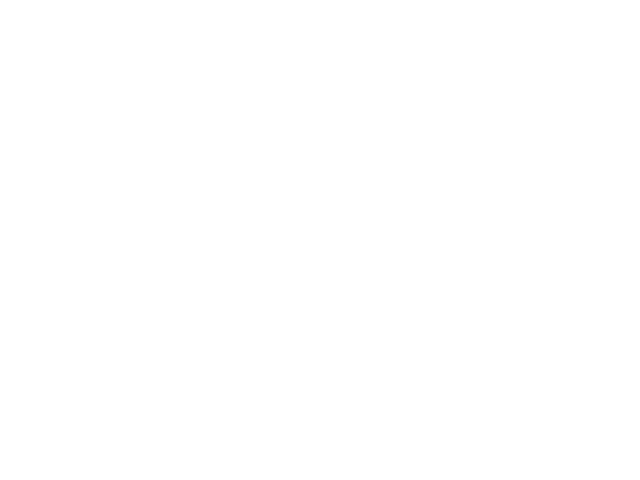

In [29]:
## Look at best learning algorithm and compare the state spaces
filt = {
 'map': "rooms",
 'expansion algorithm': "astar",
 'decision algorithm': "miniminbackup", 
}

best_la = {
    0: "plrtalearning",
    1: "dijkstralearning",
    2: "plrtalearning"
}

test = "State Space Comparison "

for m in set(data.map):
    filt["map"] = m
    pre_plot()
    uw = "NA"
    filt["unitWait"] = uw
    pre_plot()
    for ni in [1]:#set(data.numIntervals):
        filt["numIntervals"] = ni
        dat = filter_data(data, filt)
        if len(dat) > 0:
            for dm in set(data.dynmode):
                d = dat.loc[(dat["learning algorithm"] == best_la[dm]) & (dat.dynmode == dm)]
                if len(d) > 0:
                    plot_one(d, 0, None, ", ".join(map(str, (best_la[dm], long_dm[dm], long_uw(uw, ni)))))
    title = test + " " + m + " " + long_uw(uw, ni)
    plt.title(title)
    post_plot(l = (0, 100))
    for uw in set(data.unitWait) - {"NA"}:
        filt["unitWait"] = uw
        filt["numIntervals"] = 1
        dat = filter_data(data, filt)
        if len(dat) > 0:
            pre_plot()
            for dm in set(data.dynmode):
                d = dat.loc[(dat["learning algorithm"] == best_la[dm]) & (dat.dynmode == dm)]
                if len(d) > 0:
                    plot_one(d, 0, dm_colors[dm], ", ".join(map(str, (best_la[dm], long_dm[dm], long_uw(uw, ni)))))
            title = test + " " + m + " " + long_uw(uw, ni)
            plt.title(title)
            post_plot(l = (0, 100))

<IPython.core.display.Javascript object>


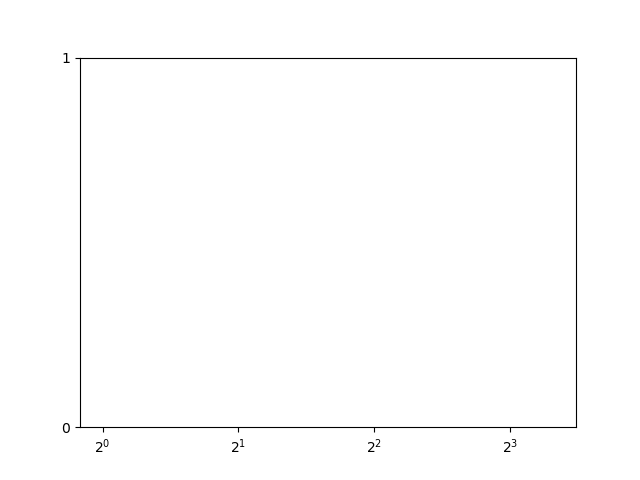

<IPython.core.display.Javascript object>


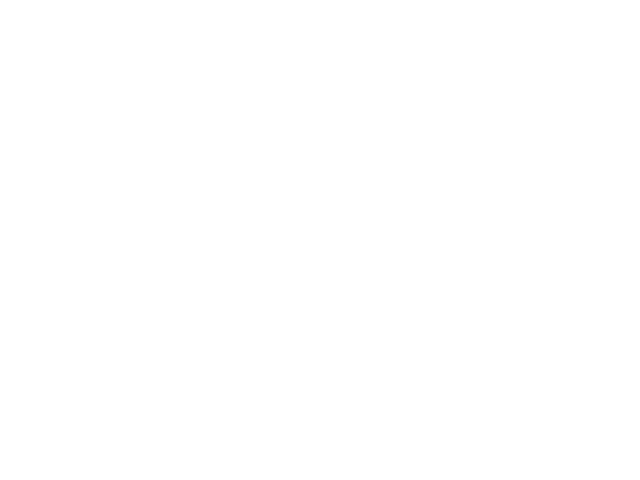

In [26]:
## Look at best learning algorithm and compare the state spaces
filt = {
 'map': "rooms",
 'expansion algorithm': "astar",
 'decision algorithm': "miniminbackup", 
}

best_la = {
    0: "plrtalearning",
    1: "dijkstralearning",
    2: "plrtalearning"
}

test = "State Space Comparison "

for m in set(data.map):
    filt["map"] = m
    pre_plot()
    uw = "NA"
    filt["unitWait"] = uw
    pre_plot()
    for ni in (3,):
        filt["numIntervals"] = ni
        dat = filter_data(data, filt)
        if len(dat) > 0:
            for dm in set(data.dynmode):
                d = dat.loc[(dat["learning algorithm"] == best_la[dm]) & (dat.dynmode == dm)]
                if len(d) > 0:
                    plot_one(d, 0, None, ", ".join(map(str, (best_la[dm], long_dm[dm], long_uw(uw, ni)))))
    for uw in set(data.unitWait) - {"NA"}:
        filt["unitWait"] = uw
        filt["numIntervals"] = 1
        dat = filter_data(data, filt)
        if len(dat) > 0:
            for dm in (0,):
                d = dat.loc[(dat["learning algorithm"] == best_la[dm]) & (dat.dynmode == dm)]
                plot_one(d, 0, None, ", ".join(map(str, (best_la[dm], long_dm[dm], long_uw(uw, ni)))))
    title = test + " " + m 
    plt.title(title)
    post_plot(l = (50, 100))

In [138]:
res = ['results_plots/Learning_comparison_rooms,_<x,y,t>,_Unit_Wait_(1.0).png',
 'results_plots/Learning_comparison_rooms,_<x,y,t>,_Unit_Wait_(0.1).png',
 'results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Unit_Wait_(0.1).png',
 'results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Unit_Wait_(1.0).png',
 'results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Safe_Interval_Wait-3.png',
 'results_plots/State_Space_Comparison__rooms_Unit_Wait_(1.0).png',
 'results_plots/State_Space_Comparison__rooms_Unit_Wait_(0.1).png',
 'results_plots/State_Space_Comparison__rooms_Safe_Interval_Wait-3.png',
 'results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Safe_Interval_Wait-1.png',
       'results_plots/State_Space_Comparison__rooms.png'
      ]

'results_plots/Learning_comparison_rooms,_<x,y,t>,_Unit_Wait_(1.0).png results_plots/Learning_comparison_rooms,_<x,y,t>,_Unit_Wait_(0.1).png results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Unit_Wait_(0.1).png results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Unit_Wait_(1.0).png results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Safe_Interval_Wait-3.png results_plots/State_Space_Comparison__rooms_Unit_Wait_(1.0).png results_plots/State_Space_Comparison__rooms_Unit_Wait_(0.1).png results_plots/State_Space_Comparison__rooms_Safe_Interval_Wait-3.png results_plots/Learning_comparison_rooms,_<x,y,i>-int,_Safe_Interval_Wait-1.png results_plots/State_Space_Comparison__rooms.png'

In [271]:
f1 = ("rooms", "EI-1", "NoGen","NoLearn")
f2 = ("rooms", "EI-1", "NoGen", "PLRTA*")

def plot_durcomp(f1, f2, maxv):
    filt1 = {
     'map': f1[0],
     "expansion scheme": f1[1],
     "gen scheme": f1[2],
     "learn scheme": f1[3]
    }
    dat1 = filter_data(data, filt1).sort_values(["lookahead", "task"])

    filt2 = {
     'map': f2[0],
     "expansion scheme": f2[1],
     "gen scheme": f2[2],
     "learn scheme": f2[3]
    }
    dat2 = filter_data(data, filt2).sort_values(["lookahead", "task"])
    
    d1 = dat1["solution duration"].copy()
    d2 = dat2["solution duration"].copy()
    d1[d1 == "na"] = float("nan")
    d2[d2 == "na"] = float("nan")
    d1 = d1.astype(float)
    d2 = d2.astype(float)
    ratio = d1.values/d2.values
    ratio = ratio[np.isfinite(ratio)]
    
    geo_mean = np.exp(np.mean(np.log(ratio)))
    geo_std = np.exp(np.sqrt(np.sum((np.log(ratio)/geo_mean)**2)/len(ratio)))
    print(geo_mean, geo_std)
    z = (np.log(1.0) - np.log(geo_mean))/np.log(geo_std)
    print(z)
    dat1.loc[dat1["solution duration"] == "na", "solution duration"] = maxv
    dat2.loc[dat2["solution duration"] == "na", "solution duration"] = maxv
    dat1["solution duration"] = dat1["solution duration"].astype(float)
    dat2["solution duration"] = dat2["solution duration"].astype(float)
    tokeep = []
    la = dat1.lookahead
    ta = dat1.task
    for i in dat1.index:
        if (ta[i], la[i]) in to_look:
            tokeep.append(i)
    dat1 = dat1.loc[tokeep]

    tokeep = []
    la = dat2.lookahead
    ta = dat2.task
    for i in dat2.index:
        if (ta[i], la[i]) in to_look:
            tokeep.append(i)
    dat2 = dat2.loc[tokeep]

    plt.figure(figsize = (9, 8))
    #plt.plot(dat1["solution duration"], dat2["solution duration"], ".k")
    plt.hexbin(dat1["solution duration"], dat2["solution duration"], gridsize=50, 
               vmin = 0.1, vmax = 10**3,cmap='Greys', bins = "log", xscale = "log", yscale = "log")
    #plt.xscale("symlog", linthresh = 90)
    #plt.yscale("symlog", linthresh = 90)
    plt.xlabel("+".join(f1[1:]) + " path length")
    plt.ylabel("+".join(f2[1:]) + " path length")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('frequency', rotation=90)
    cbar.ax.set_ylim((1, 10**3))
    plt.tight_layout()
    plt.plot([50, maxv], [50, maxv], "--k")
    plt.axis('square')
    plt.savefig("solution duration " + "+".join(f1) + " x " +  "+".join(f2), dpi = 300)
    
    dat1_better = (dat2["solution duration"].values > dat1["solution duration"].values).sum()
    neither_better = (dat2["solution duration"].values == dat1["solution duration"].values).sum()
    dat2_better = (dat2["solution duration"].values < dat1["solution duration"].values).sum()
    print("d1 better, median, d2 better")
    print(np.percentile(ratio, [5, 50, 95]))
    res = np.asarray((dat1_better, neither_better, dat2_better))
    print(res/res.sum())

0.899312381529875 1.4095967044504285
0.3091281779857393


<IPython.core.display.Javascript object>


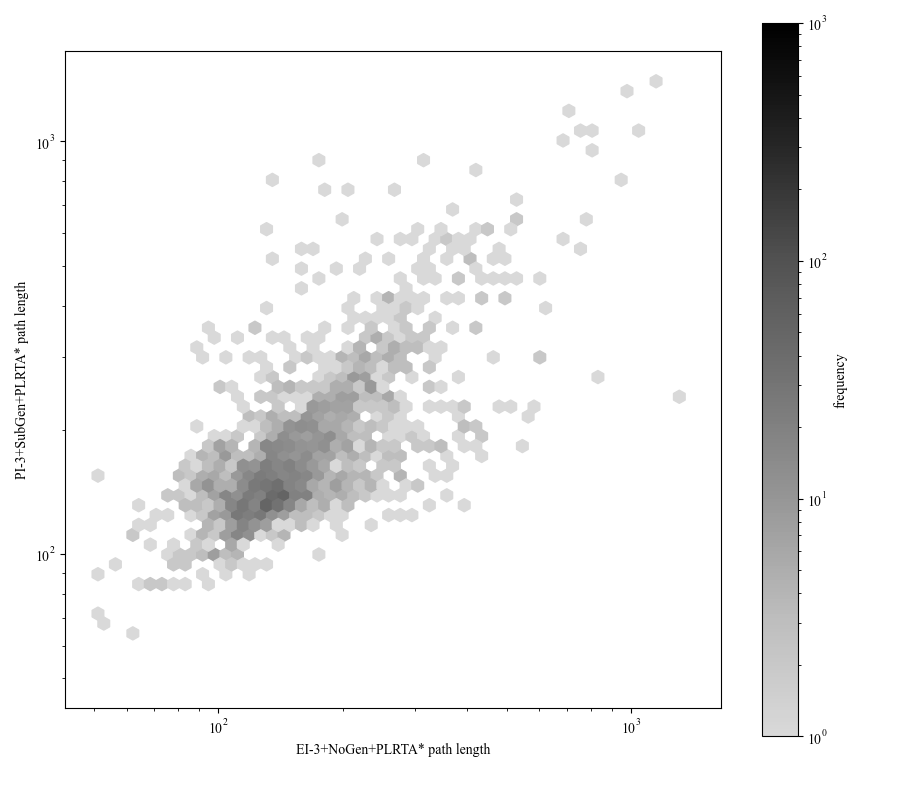

d1 better, median, d2 better
[0.5783006  0.90488878 1.42222303]
[0.48271836 0.24217655 0.27510509]


In [272]:
f1 = ("rooms", "EI-3", "NoGen","PLRTA*")
f2 = ("rooms", "PI-3", "SubGen", "PLRTA*")
plot_durcomp(f1, f2, float("inf"))

0.9392801140063731 1.422613779915077
0.17770855964105653


<IPython.core.display.Javascript object>


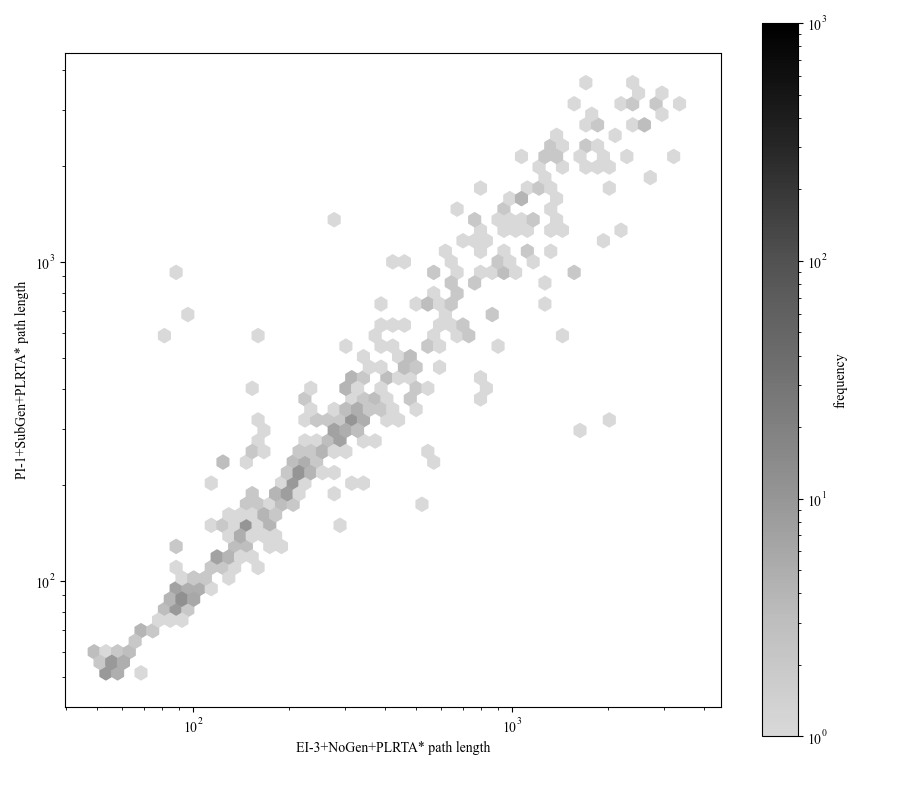

d1 better, median, d2 better
[0.58032753 0.99877691 1.32965155]
[0.39206534 0.21820303 0.38973162]


In [273]:
f1 = ("den520d", "EI-3", "NoGen","PLRTA*")
f2 = ("den520d", "PI-1", "SubGen", "PLRTA*")
plot_durcomp(f1, f2, float("inf"))

1.0255114522929643 1.1795404573738968
-0.15256004987982452


<IPython.core.display.Javascript object>


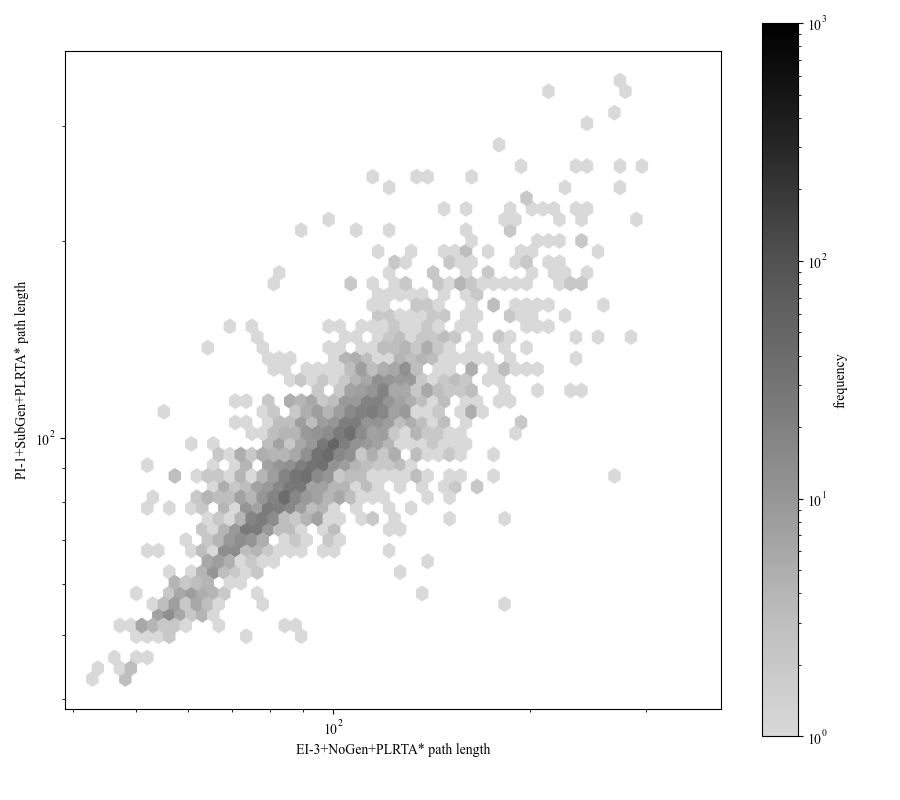

d1 better, median, d2 better
[0.7926776  1.02586268 1.34471227]
[0.30336291 0.22185894 0.47477814]


In [274]:
f1 = ("warehouse", "EI-3", "NoGen","PLRTA*")
f2 = ("warehouse", "PI-1", "SubGen", "PLRTA*")
plot_durcomp(f1, f2, float("inf"))

0.9990710085375499 1.1108369418279165
0.00884207246010889


<IPython.core.display.Javascript object>


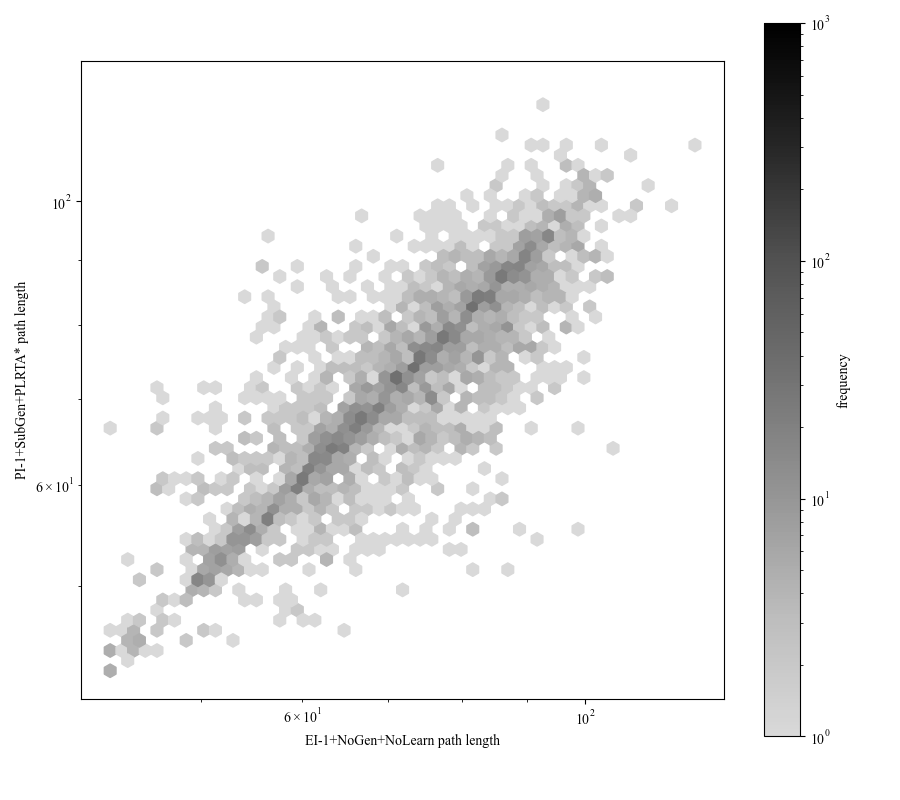

d1 better, median, d2 better
[0.84129636 0.99306385 1.19737431]
[0.47454461 0.15483419 0.37062121]


In [275]:
f1 = ("empty64x64", "EI-1", "NoGen","NoLearn")
f2 = ("empty64x64", "PI-1", "SubGen", "PLRTA*")
plot_durcomp(f1, f2, float("inf"))